In [187]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Input, Dropout, Conv1D, Flatten, GRU, GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, concatenate, GaussianNoise, Layer, BatchNormalization, Reshape
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.activations import relu, elu, tanh
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from esinet import util
from tensorflow.keras.layers import LSTM
from esinet import Simulation, Net
from esinet.forward import create_forward_model, get_info
import numpy as np
import copy
import tensorflow.keras.backend as K

In [188]:
def channel_attention_module(input_tensor, reduction_ratio=8):
    # 获取输入通道数
    channels = input_tensor.shape[-1]
    
    # 压缩阶段
    squeeze = GlobalAveragePooling1D()(input_tensor)
    
    # 激励阶段
    excitation = Dense(channels // reduction_ratio, activation='relu')(squeeze)
    excitation = Dense(channels, activation='sigmoid')(excitation)
    
    # 将激励层的输出调整形状以匹配原始输入的形状
    excitation = Reshape((1, channels))(excitation)
    
    # 重标定阶段，逐元素乘法
    scale = multiply([input_tensor, excitation],  name="multiply2")
    
    
    return scale

In [189]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=0)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    ff = LayerNormalization(epsilon=1e-6)(x)
    ff = TimeDistributed(Dense(ff_dim, activation="relu"))(ff)
    ff = Dropout(dropout)(ff)
    ff = TimeDistributed(Dense(inputs.shape[-1]))(ff)
    ff = Add()([ff, x])

    return ff

In [190]:
# Define several different loss functions
def combined_loss_transform(V):

    def loss(y_true, y_pred):
        # MSE Loss
        huber = tf.keras.losses.Huber()(y_true, y_pred)
        
        # Cosine Similarity Loss
        # 使用 tf.keras.losses.cosine_similarity，并确保结果为正值
        cosine_loss = 1+tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    
        transformed = tf.matmul(y_pred, V)
        l1_loss = tf.reduce_mean(tf.abs(transformed))
        
        # 组合损失，确保使用 tf.cast 保持类型一致
        combined = 10000 * huber + 10*cosine_loss + 100*l1_loss
        
        return combined
        
    return loss

def combined_loss_Laplactransform(L):

    def loss(y_true, y_pred):
        # MSE Loss
        huber = tf.keras.losses.Huber()(y_true, y_pred)
        
        # Cosine Similarity Loss
        # 使用 tf.keras.losses.cosine_similarity，并确保结果为正值
        cosine_loss = 1+tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    
        # 计算拉普拉斯正则化项
        # y_pred需要与拉普拉斯矩阵的维度匹配
        laplacian_reg = tf.matmul(tf.matmul(y_pred, L), y_pred, transpose_a=True)
        l1_loss = tf.reduce_mean(tf.abs(laplacian_reg))
        
        # 组合损失，确保使用 tf.cast 保持类型一致
        combined = 10000 * huber + 3*cosine_loss + 100*l1_loss
        
        return combined
        
    return loss

def wight_combined_loss(y_true, y_pred):

    # 创建一个掩码，标记非零值
    mask = tf.not_equal(y_true, 0)
    # 使用掩码过滤出非零元素
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)

    # MSE Loss
    huber = tf.keras.losses.Huber(delta=0.5)(y_true, y_pred)
    wMSE = tf.keras.losses.MeanSquaredError()(y_true_filtered, y_pred_filtered)
    
    # Cosine Similarity Loss
    # 使用 tf.keras.losses.cosine_similarity，并确保结果为正值
    cosine_loss = 1+tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    
    # 组合损失，确保使用 tf.cast 保持类型一致
    #combined = 1000 * huber + cosine_loss + wMSE
    combined = 1000 * huber + cosine_loss
    
    return combined

def wight_combined_loss2(y_true, y_pred):
    
    # 设定权重
    weights = tf.where(tf.not_equal(y_true, 0), 1.0, 0)
    # 计算加权MSE
    wmse=tf.reduce_mean(weights * tf.square(y_true - y_pred))

    # MSE Loss
    huber = tf.keras.losses.Huber(delta=0.5)(y_true, y_pred)
    # huber2 = tf.keras.losses.Huber(delta=0.1)(y_true_filter, y_pred_filter)
    
    # Cosine Similarity Loss
    # 使用 tf.keras.losses.cosine_similarity，并确保结果为正值
    cosine_loss = 1+tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    #cosine_loss2=tf.exp(cosine_loss)
    
    # 组合损失，确保使用 tf.cast 保持类型一致
    combined = 1000 * huber + 1*cosine_loss + 1000*wmse

    return combined

def Wight_huber_loss(y_true, y_pred):
    
    beta=1.0
    weights = tf.where(tf.not_equal(y_true, 0), 1.0, 0.01)
    diff = K.abs(y_true - y_pred)
    loss = tf.where(K.less(diff, beta), weights*0.5 * K.square(diff) / beta, weights*diff - 0.5 * beta)
    return K.mean(loss, axis=-1)
    
def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))
def combined_loss(y_true, y_pred):

    print(y_pred.shape)
    print(y_true.shape)
    # MSE Loss
    huber = tf.keras.losses.Huber()(y_true, y_pred)

    sparsity_loss = sparsity(y_true, y_pred)

    print(sparsity_loss)
    
    # 组合损失，确保使用 tf.cast 保持类型一致
    combined = huber + 0.1 * sparsity_loss
    return combined

In [191]:
# Define several different dropout functions
class ChannelRegionDropout(Layer):
    def __init__(self, block_size=3, **kwargs):
        super(ChannelRegionDropout, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs, training=None):
        if training is None:
            training = K.learning_phase()

        def dropped_inputs():
            input_shape = tf.shape(inputs)
            batch_size = input_shape[0]
            timesteps = input_shape[1]
            channels = input_shape[2]

            # 计算需要生成的掩码大小
            mask_size = channels - self.block_size + 1

            # 随机选择一个起始点
            start_channel = tf.random.uniform(shape=(), minval=0, maxval=mask_size, dtype=tf.int32)

            # 生成基础掩码
            mask = tf.concat([
                tf.ones((batch_size, timesteps, start_channel), dtype=inputs.dtype),
                tf.zeros((batch_size, timesteps, self.block_size), dtype=inputs.dtype),
                tf.ones((batch_size, timesteps, channels - start_channel - self.block_size), dtype=inputs.dtype)
            ], axis=2)

            return inputs * mask

        return K.in_train_phase(dropped_inputs(), inputs, training=training)

    def compute_output_shape(self, input_shape):
        return input_shape

class ChannelDropout(Layer):
    def __init__(self, drop_rate, block_size, **kwargs):
        super(ChannelDropout, self).__init__(**kwargs)
        self.drop_rate = drop_rate
        self.block_size = block_size

    def build(self, input_shape):
        super(ChannelDropout, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            input_shape = tf.shape(inputs)
            batch_size = input_shape[0]
            timesteps = input_shape[1]
            channels = input_shape[2]

            # 计算缩减后的通道数
            reduced_channels = (channels + self.block_size - 1) // self.block_size

            # 生成基本掩码
            random_tensor = tf.random.uniform((batch_size, timesteps, reduced_channels), dtype=inputs.dtype)
            dropout_mask = tf.cast(random_tensor < (1 - self.drop_rate), inputs.dtype)

            # 扩展掩码以覆盖原始维度
            dropout_mask = tf.tile(dropout_mask, [1, 1, self.block_size])
            # 裁剪掩码以匹配输入尺寸
            dropout_mask = tf.slice(dropout_mask, [0, 0, 0], [batch_size, timesteps, channels])

            # 应用掩码
            return inputs * dropout_mask
        else:
            return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

class CustomDropout(Layer):
    def __init__(self, drop_rate, block_size_time, block_size_channel, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.drop_rate = drop_rate
        self.block_size_time = block_size_time
        self.block_size_channel = block_size_channel

    def build(self, input_shape):
        super(CustomDropout, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            input_shape = tf.shape(inputs)
            batch_size = input_shape[0]
            timesteps = input_shape[1]
            channels = input_shape[2]

            # 计算缩减后的时间步和通道数
            reduced_timesteps = (timesteps + self.block_size_time - 1) // self.block_size_time
            reduced_channels = (channels + self.block_size_channel - 1) // self.block_size_channel

            # 生成基本掩码
            random_tensor = tf.random.uniform((batch_size, reduced_timesteps, reduced_channels), dtype=inputs.dtype)
            dropout_mask = tf.cast(random_tensor < (1 - self.drop_rate), inputs.dtype)

            # 扩展掩码以覆盖原始维度
            dropout_mask = tf.tile(dropout_mask, [1, self.block_size_time, self.block_size_channel])
            # 裁剪掩码以匹配输入尺寸
            dropout_mask = tf.slice(dropout_mask, [0, 0, 0], [batch_size, timesteps, channels])

            # 应用掩码
            return inputs * dropout_mask
        else:
            return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

class LateSpatialDropout1D(tf.keras.layers.Layer):
    def __init__(self, rate, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.spatial_dropout = tf.keras.layers.SpatialDropout1D(rate)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step,
                    lambda: inputs,
                    lambda: self.spatial_dropout(inputs, training=training))

        if training:
            self._train_counter.assign_add(1)

        return x

In [192]:
# 对输入eeg进行归一化，采用Z分数标准化通常是首选，因为它使数据具有统一的尺度，而且能较好地处理数据的异常值和噪声
def custom_prep_data(data):

    data = np.swapaxes(data, 1,2)

    # 获取数据维度
    num_samples, num_timepoints, num_channels = data.shape
    
    # 将数据类型转换为 np.float32
    data = data.astype(np.float32)
    
    # 对每个样本（脑电信号的一个时间点）进行处理
    for i in range(num_samples):
        for j in range(num_timepoints):
            # 获取当前样本的数据
            sample_data = data[i, j, :]
            
            # 假设你想要进行去除平均值和标准化的预处理
            # 去除平均值
            sample_data_mean = np.mean(sample_data)
            sample_data_std = np.std(sample_data)
            sample_data -= sample_data_mean
            
            # 标准化
            if sample_data_std != 0:
                sample_data /= sample_data_std
        
            # 更新数据
            data[i, j, :] = sample_data
    print("The shape of EEG is", data.shape)
    
    return data

# 对源信号进行归一化，这种最大绝对值归一化能够保持数据的结构和正负性，仅改变数据的尺度。这意味着信号的正负模式被保留。
def custom_prep_source(data):
    
    # 将数据类型转换为 np.float32
    data = data.astype(np.float32)
    
    for i, y_sample in enumerate(data):
        max_abs_vals=np.array(np.max(abs(data[i])))
        max_abs_vals[max_abs_vals == 0] = 1
        data[i] /= max_abs_vals   

    data = np.swapaxes(data, 1,2)
    print("The shape of source is", data.shape)
    
    return data

In [193]:
# 定义学习率调度函数
def lr_schedule(epoch):
    # 根据训练周期(epoch)来动态调整学习率
    if epoch < 50:
        return 0.0003  
    elif epoch < 100:
        return 0.0002 
    elif epoch < 150:
        return 0.0001  
    else:
        return 0.00005 

# 创建学习率调度器,损失函数有余弦相似度 CosineSimilarity, tf.keras.losses.Huber(), MeanAbsoluteError, MeanSquaredError
lr_scheduler = LearningRateScheduler(lr_schedule)

In [194]:
# 超参数定义, kernel_initializer='he_uniform', kernel_initializer='glorot_uniform' dropout=dropout_rate
n_channels = 60
n_dipoles = 1284
n_dense_units = 200  # 减少单元数 200
n_lstm_units1 = 100   # 减少单元数 100
n_lstm_units2 = 200    # 减少单元数 100
dropout_rate = 0.2 # 0.2
batch_size = 32 # 32 2048 2的次幂
epochs = 180
noise_factor=0.1
# 导入邻接矩阵V
V=np.load('V.npy')
# 导入拉普拉斯矩阵L
L=np.load('L.npy')

# 输入层
inputs = Input(shape=(None, n_channels), name='Input')
#noisy_input = GaussianNoise(stddev=noise_factor)(inputs, training=True)
# 并行处理输入
fc1 = Dense(n_dense_units, activation="relu")(inputs)
fc2 = Dense(n_dense_units, activation="relu")(fc1)
fc3 = Dense(n_dense_units, activation="relu")(fc2)
add1 = Add()([fc1, fc3])
add1 = tanh(add1)
add1 = Dropout(dropout_rate)(add1)
bi_lstm = Bidirectional(LSTM(n_lstm_units1, return_sequences=True, dropout=dropout_rate), name='BiLSTM1')(inputs)

# 合并并行层的输出
merged = concatenate([add1, bi_lstm], axis=-1)
lstm = Bidirectional(LSTM(n_lstm_units2, return_sequences=True), name='BiLSTM2')(merged)

# Transformer层
transformer_block = transformer_encoder(lstm, head_size=128, num_heads=4, ff_dim=600)

# 输出层
direct_out = TimeDistributed(Dense(n_dipoles, activation="linear"), name='Direct_Output')(transformer_block)
CATT = channel_attention_module(direct_out)

# skip_connection = Dense(n_dipoles, activation="tanh")(inputs)  # 需要通过一个调整层来适配维度
# outputs = Add()([CATT, skip_connection])

# 创建和编译模型
model = tf.keras.Model(inputs=inputs, outputs=CATT, name='Simplified_Hybrid_Model')
model.compile(loss=wight_combined_loss2, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))

# 打印模型概要
model.summary()

Model: "Simplified_Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 60)]   0           []                               
                                                                                                  
 dense_100 (Dense)              (None, None, 200)    12200       ['Input[0][0]']                  
                                                                                                  
 dense_101 (Dense)              (None, None, 200)    40200       ['dense_100[0][0]']              
                                                                                                  
 dense_102 (Dense)              (None, None, 200)    40200       ['dense_101[0][0]']              
                                                                            

In [195]:
# 加载测试数据
x= np.load('x1.npy')
y= np.load('y1.npy')
print(x.shape)
print(y.shape)

(20000, 60, 26)
(20000, 1284, 26)


In [196]:
 # 对信号进行预处理
x = custom_prep_data(x)
y = custom_prep_source(y)
# y = np.swapaxes(y, 1,2)

The shape of EEG is (20000, 26, 60)
The shape of source is (20000, 26, 1284)


In [197]:
# 使用数据生成器进行训练
def data_generator(x, y, batch_size):
    num_samples = len(x)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            yield x[batch_indices], y[batch_indices]

In [198]:
# Split data into training and validation sets
split_index = int(0.9 * len(x))
x_train, x_val = x[:split_index], x[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [199]:
# Create data generators for training and validation
train_generator = data_generator(x_train, y_train, batch_size)
val_generator = data_generator(x_val, y_val, batch_size)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

In [200]:
# 计算每个epoch的步骤和验证步骤
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_val) // batch_size

In [201]:
# 训练模型时使用学习率调度器
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]  # 添加学习率调度器回调
)

Epoch 1/180
562/562 [==============================] - 29s 35ms/step - loss: 3.6202 - val_loss: 2.9702 - lr: 3.0000e-04
Epoch 2/180
562/562 [==============================] - 18s 31ms/step - loss: 2.8421 - val_loss: 2.5235 - lr: 3.0000e-04
Epoch 3/180
562/562 [==============================] - 18s 31ms/step - loss: 2.2662 - val_loss: 2.0219 - lr: 3.0000e-04
Epoch 4/180
562/562 [==============================] - 18s 32ms/step - loss: 2.0083 - val_loss: 1.9136 - lr: 3.0000e-04
Epoch 5/180
562/562 [==============================] - 18s 33ms/step - loss: 1.8745 - val_loss: 1.7776 - lr: 3.0000e-04
Epoch 6/180
562/562 [==============================] - 18s 33ms/step - loss: 1.7561 - val_loss: 1.6765 - lr: 3.0000e-04
Epoch 7/180
562/562 [==============================] - 18s 32ms/step - loss: 1.6592 - val_loss: 1.5805 - lr: 3.0000e-04
Epoch 8/180
562/562 [==============================] - 19s 33ms/step - loss: 1.5626 - val_loss: 1.5536 - lr: 3.0000e-04
Epoch 9/180
562/562 [===================

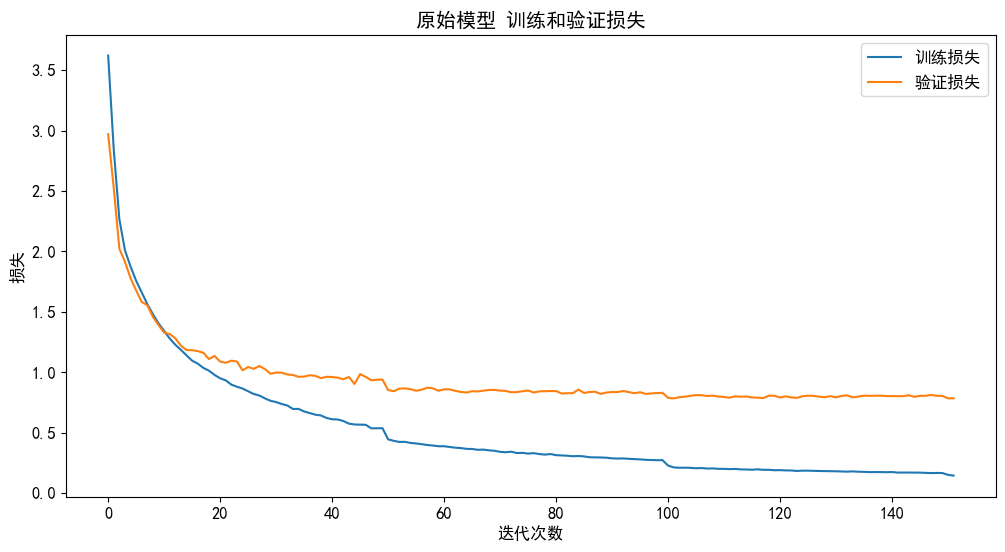

In [202]:
# 绘制验证损失和训练损失
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置字体大小
plt.rcParams['font.size'] = 12

# 设置图像大小
plt.figure(figsize=(12, 6))

# 绘制训练和验证损失
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.xlabel('迭代次数')
plt.ylabel('损失')
plt.title('原始模型 训练和验证损失')
plt.legend()
plt.show()

In [203]:
# 保存模型
model.save('model11', save_format='tf')

INFO:tensorflow:Assets written to: model11\assets


INFO:tensorflow:Assets written to: model11\assets
